<a href="https://nbviewer.jupyter.org/github/project-ida/phonons/blob/anthony-sandbox/string.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# Introduction

In this notebook, we explore phonon modes by analyzing a system of springs and masses. 

In [1]:
# loading some common python libraries

import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import Image
from IPython.core.display import HTML 
import sympy as sp
#from google.colab.output._publish import javascript
mathjaxurl = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
sp.init_printing(use_latex='mathjax') 
import matplotlib.patches as patches
import pandas as pd

## Classes to work with

The way that this code is written is with object oriented programming. In the code below, I define the two classes come up a lot in the code. The object class represents a standard mass, it has atributes like mass, position, et cetera; it also has functions that help with the simulation. The spring class is defined by the two objects that it connects and the spring constant, and is equiped with functions that allow it to interact with the objects attached.

In [2]:
class object:
    def __init__(self, mass = 1, x0 = 0, v0 = 0, a0 = 0, wall = False, dt = 0.0001):
        #Establishing the parameters of an object
        self.mass = mass
        self.position = x0
        self.velocity = v0
        self.acceleration = a0
        self.energy = 0.5 * self.mass * (self.velocity)**2
        self.dt = dt
        
        #self.wall is a True-False statement as to whether the object is a wall
        self.wall = wall
        
        #self.force is a list of all of the different forces that are acting on the object
        self.forces = []
        
        #self.xhistory is all of the different positions the object has gone through; the purpose of this is for graphing
        self.xhistory = []
        
        #Keep track of initial conditions for resets
        self.xstart = x0
        self.vstart = v0
        self.astart = a0

    def timestep(self):
        #Processing a timestep
        self.xhistory.append(self.position)
        self.position = self.position + self.velocity * self.dt
        self.velocity = self.velocity + self.acceleration * self.dt
        self.energy = 0.5 * self.mass * (self.velocity) ** 2

    def force(self, Force):
        #We add a force to our list of forces
        self.forces.append(Force)

    def Newton(self):
        #Based on our list of forces, we use Newton's Second Law to find the net force and net acceleration
        Force = 0
        for F in self.forces:
            Force += F
        if self.wall == False:
            self.acceleration = Force / self.mass
        else:
            self.acceleration = 0
        self.forces = []
    
    def displace(self, x, v):
        #This is a function that displaces an object
        self.position += x
        self.velocity += v
        
    def reset(self):
        #Reset everything
        self.position = self.xstart
        self.velocity = self.vstart
        self.acceleration = self.astart
        self.energy = 0.5 * self.mass * (self.velocity)**2
        self.xhistory = []

In [3]:
class spring:
    def __init__(self, k, object1, object2, rest_length = 0, periodic = False, boundary = 0):
        #Initialize the parameters of the spring
        self.k = k
        self.obj1 = object1
        self.obj2 = object2
        self.rest = rest_length
        self.energy = 0
        
        #If the spring is the spring in the periodic boundary that loops around, self.periodic is true, and 
        #self.boundary is how much that is looped
        self.periodic = periodic
        self.boundary = boundary

    def spring_force(self):
        #Calculate the magnitude of the spring force based on the position of the attached masses and the 
        #parameters of the spring. Then add that force to the list of forces for each object
        x1 = self.obj1.position
        x2 = self.obj2.position
        if self.periodic:
            if x2 > x1:
                x2 += -self.boundary
            else:
                x2 += self.boundary
        if x2 > x1:
            deltax = (x2 - x1 - self.rest)
        else:
            deltax = (x2 - x1 + self.rest)
        f = self.k * deltax
        self.obj1.force(f)
        self.obj2.force(-f)
        self.energy = 0.5 * self.k * (deltax) ** 2

In [4]:
def damping(obj, gamma):
    #Standard damping force, but it isn't used much
    v = obj.get_v()
    obj.force(-gamma*v)

In [5]:
def center(objects):
    #This transfers the system into the center of mass reference frame
    p_tot = 0
    m_tot = 0
    for obj in objects:
        m_tot += obj.mass
        p_tot += obj.mass*obj.velocity
    v_cm = p_tot/m_tot
    for obj in objects:
        obj.displace(0, -v_cm)

# Simulation

With the classes we are using defined, we can go on and do a simulation of the system. There are three simulations we run at this point: one without any special boundaries, one with the end masses attached to wallls and one with periodic boundaries. For all of the simulations, we plot the position as a function of time and print out the graph.

## No Boundaries

In this box, I set up the system that is being simulated. The system is composed of $N$ identical masses and a similar number of identical springs initially set up so that all of the springs are at their rest length. For this particular simulation, we don't have any special boundaries; so we just have $N$ masses connected by springs that are oscillating freely.

In [6]:
end_time = 100
iters = 100000
N = 9
dt = end_time/iters
l = 1
gamma = 0
mass = 5
k = 5
objects = []
springs = []
wall_boundaries = False
periodic = False
if wall_boundaries:
    objects.append(object(x0 = 0, wall = True))
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*(n + 1), dt = dt))
    objects.append(object(x0 = l*(N + 1), wall = True))
    for m in range(N+1):
        springs.append(spring(k, objects[m], objects[m+1], rest_length = l))
        
elif periodic:
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k,objects[m], objects[m+1],rest_length = l))
    springs.append(spring(k, objects[N-1], objects[0], rest_length = l, periodic = True, boundary = l*N))
        
else:
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k,objects[m],objects[m+1],rest_length = l))

Now we run the simulation by slightly displacing one of the objects and traveling to the center of mass reference frame. After the simulation runs, the script plots the positions of the masses as a funciton of time. Each of the lines represents the motion of a mass through time. 

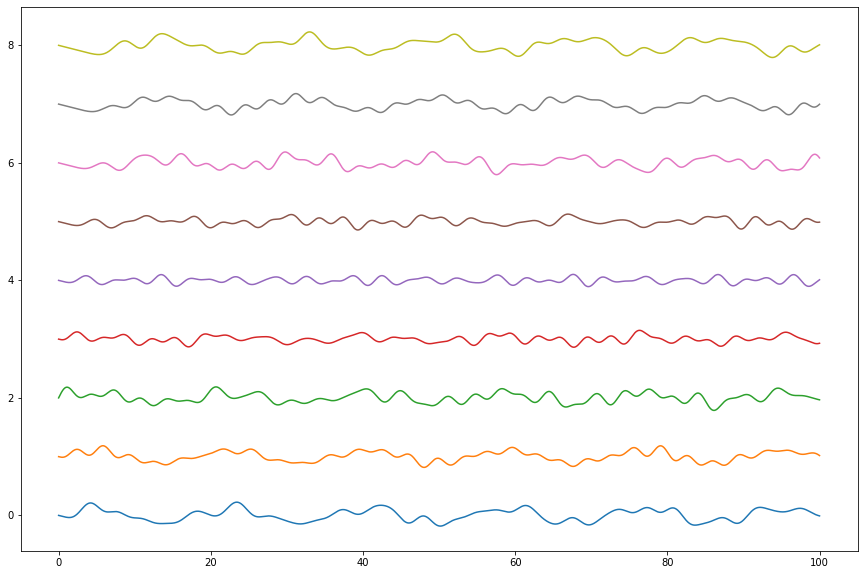

In [7]:
objects[2].displace(0, 0.3)
center(objects)

time = []
for i in range(iters):
    time.append(i*dt)
    for s in springs:
        s.spring_force()
    for obj in objects:
#        damping(obj, gamma)
        obj.Newton()
        obj.timestep()
plt.figure(figsize = (15,10))
for obj in objects:
    plt.plot(time, obj.xhistory)
plt.show()

## Walled Boundaries

This simulation is run much the same as above, except now the end masses in the string are connected to walls via springs. The way that I have defined walls is that they are objects that do not accelerate no matter the force applied. So in the simulation, I have $N+2$ objects connected by springs, the first and last of which are wall objects that are stationary.

In [8]:
end_time = 100
iters = 100000
N = 9
dt = end_time/iters
l = 1
gamma = 0.1
objects = []
springs = []
wall_boundaries = True
periodic = False
if wall_boundaries:
    objects.append(object(x0 = 0, wall = True))
    for n in range(N):
        objects.append(object(mass = 5, x0 = l*(n + 1), dt = dt))
    objects.append(object(x0 = l*(N + 1), wall = True))
    for m in range(N+1):
        springs.append(spring(5, objects[m], objects[m+1], rest_length = l))
        
elif periodic:
    for n in range(N):
        objects.append(object(5, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(5,objects[m], objects[m+1],rest_length = l))
    springs.append(spring(5, objects[N-1], objects[0], rest_length = l, periodic = True, boundary = l*N))
        
else:
    for n in range(N):
        objects.append(object(5, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(5,objects[m],objects[m+1],rest_length = l))

As before, the simulation is run and the position of each object is graphed as a function of time. The first and last objects in the string are walls and so they remain where they are for the entire simulation.

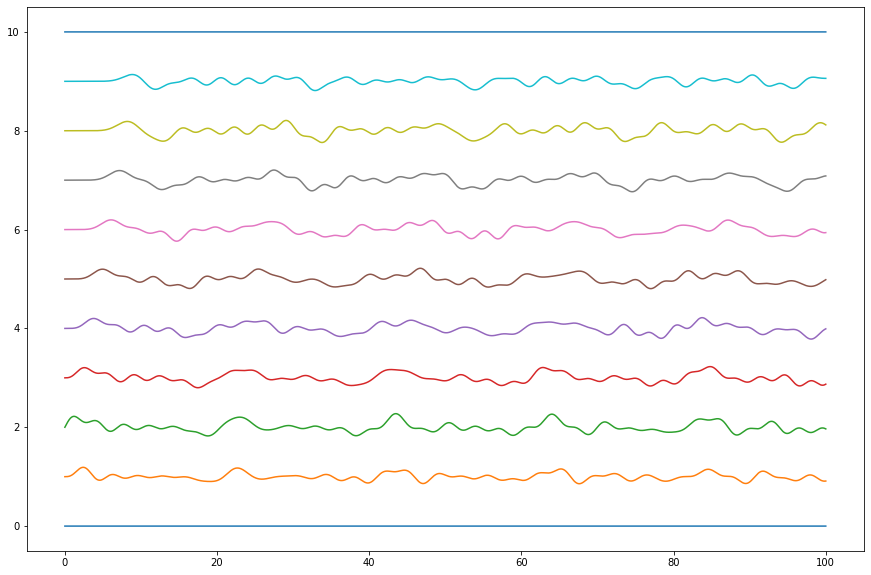

In [9]:
objects[2].displace(0, 0.3)

time = []
for i in range(iters):
    time.append(i*dt)
    for s in springs:
        s.spring_force()
    for obj in objects:
#        damping(obj, gamma)
        obj.Newton()
        obj.timestep()
        
plt.figure(figsize = (15,10))
for obj in objects:
    plt.plot(time, obj.xhistory)
plt.show()

## Periodic Boundaries

This simulation is defined with periodic boundaries; this means that the last object in the string is connected to the first by a spring. The periodicy is of length $Nl$ where $l$ is the rest length of the spring. 

In [10]:
end_time = 100
iters = 100000
N = 9
dt = end_time/iters
l = 1
gamma = 0.1
objects = []
springs = []
wall_boundaries = False
periodic = True
if wall_boundaries:
    objects.append(object(x0 = 0, wall = True))
    for n in range(N):
        objects.append(object(mass = 5, x0 = l*(n + 1), dt = dt))
    objects.append(object(x0 = l*(N + 1), wall = True))
    for m in range(N+1):
        springs.append(spring(5, objects[m], objects[m+1], rest_length = l))
        
elif periodic:
    for n in range(N):
        objects.append(object(5, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(5,objects[m], objects[m+1],rest_length = l))
    springs.append(spring(5, objects[N-1], objects[0], rest_length = l, periodic = True, boundary = l*N))
        
else:
    for n in range(N):
        objects.append(object(5, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(5,objects[m],objects[m+1],rest_length = l))

We displace one of the masses and then go into the center of mass reference frame so the system is stationary. After we run the simulation, the script returns a graph of the position of the masses as a function of time. 

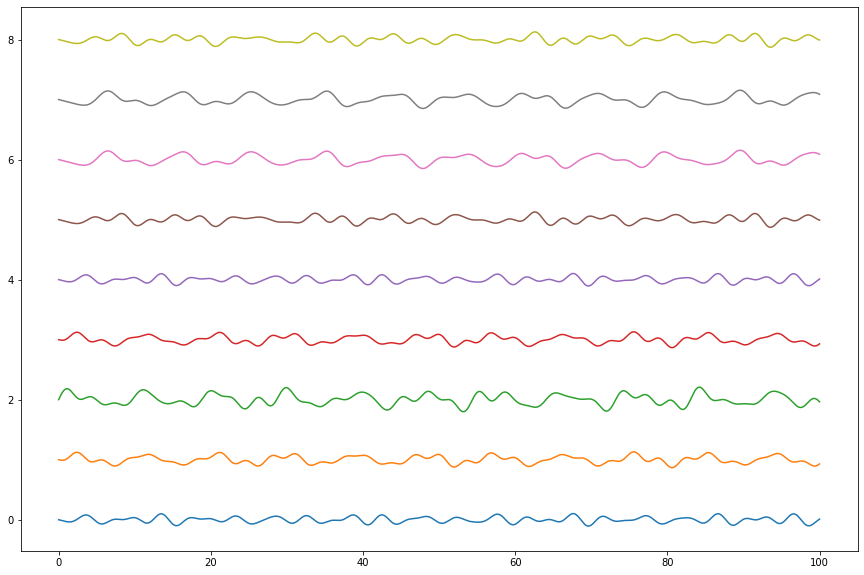

In [11]:
objects[2].displace(0, 0.3)
center(objects)

time = []
for i in range(iters):
    time.append(i*dt)
    for s in springs:
        s.spring_force()
    for obj in objects:
#        damping(obj, gamma)
        obj.Newton()
        obj.timestep()

plt.figure(figsize = (15,10))
for obj in objects:
    plt.plot(time, obj.xhistory)
plt.show()

# Normal Modes

Now that we have a working simulation, will now isolate the normal modes of the system. Normal modes are by 
definition forms of oscillation in which all masses oscillate with the same frequency. It turns out that we can take
$$x_n = A\cos\left(\frac{2\pi}{\lambda}nl - \omega t\right)$$
and in a normal mode all masses will oscillate in accordance to that formula. Then for a given normal mode, we can excite our system into a normal mode by exciting the masses so that they match the normal mode for $t = 0$, or:
$$x_n(0) = A\cos\left(\frac{2\pi}{\lambda}nl\right)$$
However, normal modes must adhere to boundary conditions of the system so only certain values of $\lambda$ are allowed.

## Walled Boundaries

For walled boundaries, the walls are always stationary so all normal modes must keep the walls stationary. This implies that the walls must always be nodes of a wave, and the total length of the wall is an integer multiple of half the wavelength or:
$$j\frac{\lambda}{2} = (N+1)l$$
where $j$ is an integer (the total length between the walls is $(N+1)l$ as there are that many springs with rest length $l$ between the walls). Solving for $\lambda$, we see that:
$$\lambda = \frac{2(N+1)l}{j}$$
Substituting into our expression for $x_n(0)$, we get that:
$$x_n(0) = A\cos\left(\frac{j\pi}{N+1}n\right)$$
Now we run a series of simulations of the normal modes for every value of $j$ between $1$ and $N$. We do this by displacing each mass by the $x_n(0)$ as given by the formula. 

In [12]:
end_time = 10
iters = 100000
N = 4
dt = end_time/iters
l = 1
mass = 5
k = 5
gamma = 0.1
objects = []
springs = []
wall_boundaries = True
periodic = False
if wall_boundaries:
    objects.append(object(x0 = 0, wall = True))
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*(n + 1), dt = dt))
    objects.append(object(x0 = l*(N + 1), wall = True))
    for m in range(N+1):
        springs.append(spring(5, objects[m], objects[m+1], rest_length = l))
        
elif periodic:
    for n in range(N):
        objects.append(object(k, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k,objects[m], objects[m+1],rest_length = l))
    springs.append(spring(k, objects[N-1], objects[0], rest_length = l, periodic = True, boundary = l*N))
        
else:
    for n in range(N):
        objects.append(object(5, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(5,objects[m],objects[m+1],rest_length = l))

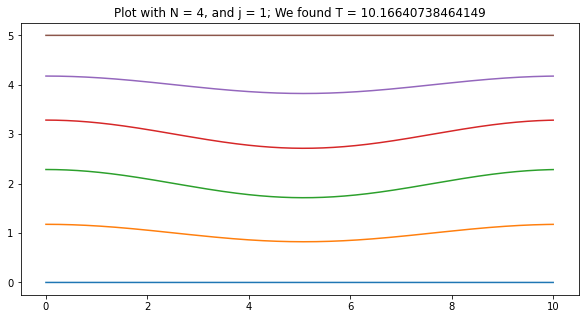

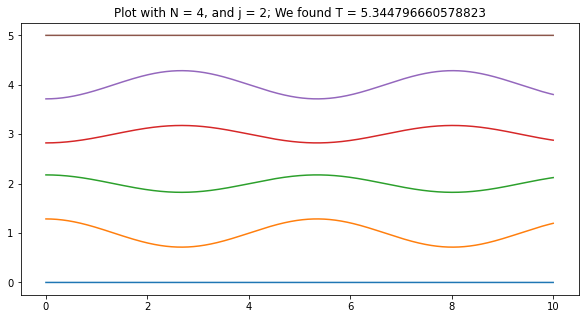

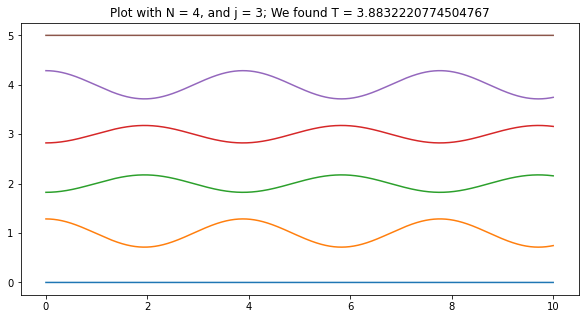

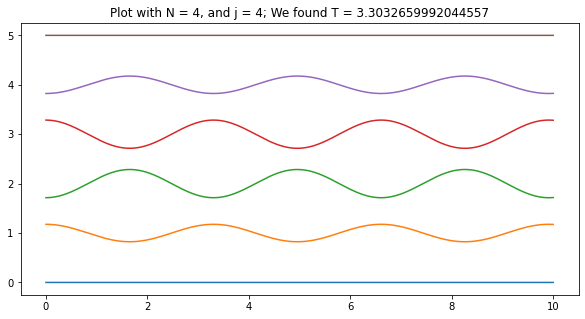

In [13]:
omegas = []
for j in range(1, N + 1):
    lmbda = 2*(N+1)*l/j
    for obj in objects:
        obj.reset()
    n = 0
    for obj in objects:
        deltax = 0.3*np.sin(2*np.pi/lmbda*n*l)
        n += 1
        obj.displace(deltax, 0)
    
    count = 0
    omega_sum = 0
    time = []
    for i in range(iters):
        time.append(i*dt)
        for s in springs:
            s.spring_force()
        for obj in objects:
    #        damping(obj, gamma)
            obj.Newton()
            if not (obj.position - obj.xstart) == 0:
                omega_sum += -obj.acceleration/(obj.position - obj.xstart)
                count += 1
            obj.timestep()
    omega_avg = np.sqrt(omega_sum/count)
    omegas.append(omega_avg)
    period = 2*np.pi/omega_avg
    plt.figure(figsize = (10,5))
    for obj in objects:
        plt.plot(time, obj.xhistory)
    title = "Plot with N = " + str(N) + ", and j = " + str(j) + "; We found T = " + str(period)
    plt.title(title)
    plt.show()

In the simulations, we also measured the angular frequency of oscillation by taking the ratio between the acceleration and posistion of a mass. As the position of a mass is
$$x_n = A\cos\left(\frac{2\pi}{\lambda}nl - \omega t\right)$$
and the acceleration is
$$a_n = -\omega^2 A\cos\left(\frac{2\pi}{\lambda}nl - \omega t\right) = -\omega^2 x_n$$
We can quickly see that $\omega = \sqrt{-a_n/x_n}$. To measure this, I averaged $-a_n/x_n$ over all the masses and all the timesteps; taking the square root of this value gives a measured value $\omega_j$ for that normal mode (the period associated with the value of $\omega_j$ is what is reported on the graphs).

We can compare this measured angular frequency to a theoretical one. By doing force analysis, we see that:
$$ma_n = k(x_{n+1} + x_{n-1} - 2x_n)$$
If we take $x_n = A\cos(\frac{2\pi}{\lambda}nl - \omega t)$, then we substitute and simplify. The result is:
$$\omega = \sqrt{\frac{2k}{m}\left(1 - \cos\left(\frac{2\pi l}{\lambda}\right)\right)}$$
Which is a dispersion relationship which relates the angular frequency of oscillation to the wavelength. In the graph below, we plot the measured angular freqencies against the theoretical one.

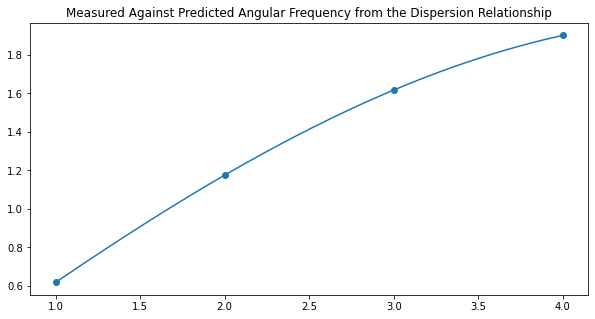

In [14]:
plt.figure(figsize = (10,5))
plt.title("Measured Against Predicted Angular Frequency from the Dispersion Relationship")
plt.scatter(range(1, N+1), omegas)
i = np.arange(1, N, 0.01)
omega = np.sqrt(2*k/mass*(1 - np.cos(np.pi*i/((N+1)))))
plt.plot(i, omega)
plt.show()

## Periodic Boundaries

For systems with periodic boundaries, we have that the total length of the system must be an integer multiple of the wavelength. This is because when we travel back to the same object, that object must have the same phase as itself. 
$$j\lambda = Nl$$
Substituting $\lambda$ into the expression for $x_n(0)$, we get that
$$x_n(0) = A\cos\left(\frac{2j\pi}{N}n\right)$$
We displace the masses as such and simulate what happens next.

In [15]:
end_time = 10
iters = 100000
N = 10
dt = end_time/iters
l = 1
mass = 5
k = 5
gamma = 0.1
objects = []
springs = []
wall_boundaries = False
periodic = True
if wall_boundaries:
    objects.append(object(x0 = 0, wall = True))
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*(n + 1), dt = dt))
    objects.append(object(x0 = l*(N + 1), wall = True))
    for m in range(N+1):
        springs.append(spring(5, objects[m], objects[m+1], rest_length = l))
        
elif periodic:
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k, objects[m], objects[m+1],rest_length = l))
    springs.append(spring(k, objects[N-1], objects[0], rest_length = l, periodic = True, boundary = l*N))
        
else:
    for n in range(N):
        objects.append(object(5, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(5,objects[m],objects[m+1],rest_length = l))

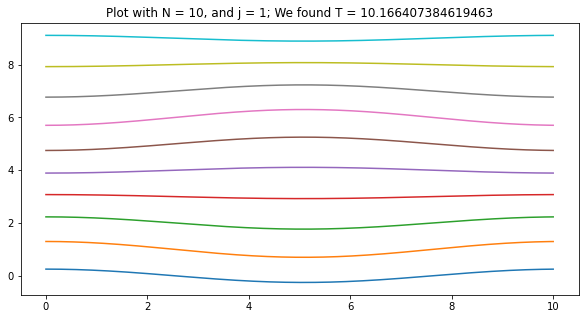

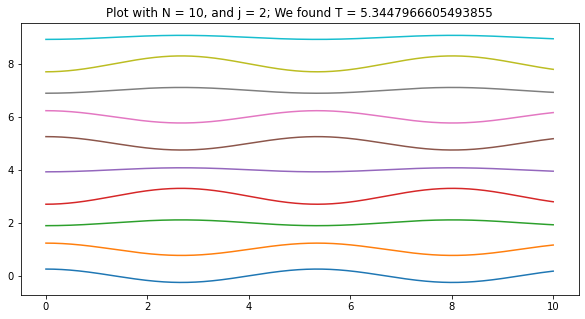

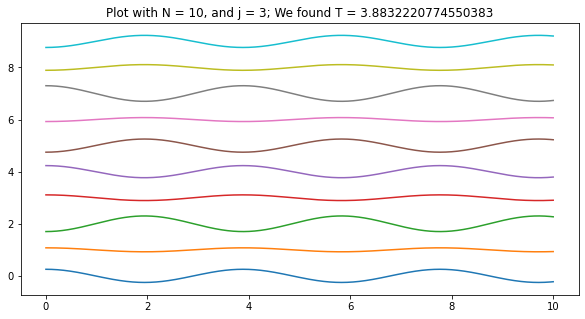

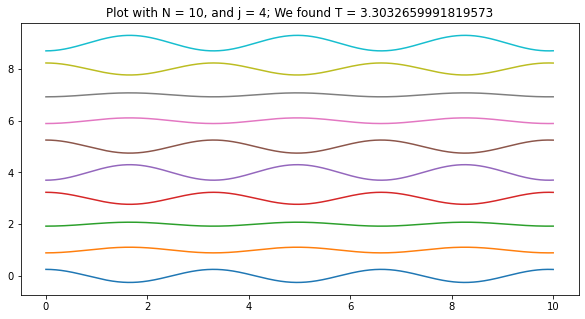

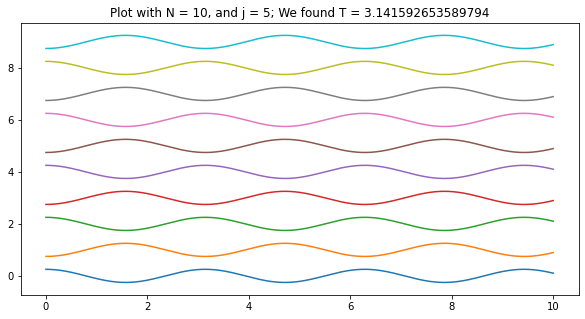

In [16]:
omegas = []
for j in range(1, int((N+1)/2 + 1)):
    lmbda = N*l/j
    for obj in objects:
        obj.reset()
    n = 0
    for obj in objects:
        deltax = 0.3*np.sin(2*np.pi/lmbda*n*l + 1)
        n += 1
        obj.displace(deltax, 0)
    
    count = 0
    omega_sum = 0
    time = []
    for i in range(iters):
        time.append(i*dt)
        for s in springs:
            s.spring_force()
        for obj in objects:
    #        damping(obj, gamma)
            obj.Newton()
            if not (obj.position - obj.xstart) == 0:
                omega_sum += -obj.acceleration/(obj.position - obj.xstart)
                count += 1
            obj.timestep()
    if not count == 0:
        omega_avg = np.sqrt(omega_sum/count)
    else:
        omega_avg = 0
    omegas.append(omega_avg)
    period = 2*np.pi/omega_avg
    plt.figure(figsize = (10,5))
    for obj in objects:
        plt.plot(time, obj.xhistory)
    title = "Plot with N = " + str(N) + ", and j = " + str(j) + "; We found T = " + str(period)
    plt.title(title)
    plt.show()

As before, we measure the angular frequency and compare those measurements against a plot of the dispersion relationship. We should see that they match quite well. 

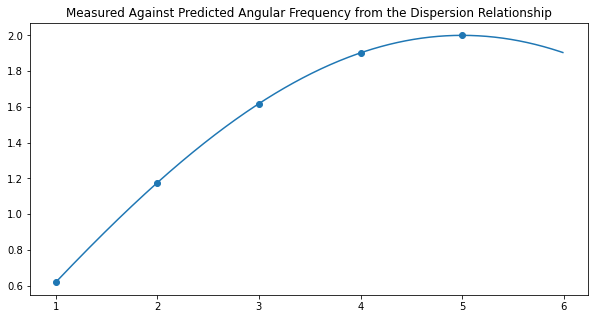

In [17]:
plt.figure(figsize = (10,5))
plt.title("Measured Against Predicted Angular Frequency from the Dispersion Relationship")
plt.scatter(range(1, int((N+1)/2 + 1)), omegas)
i = np.arange(1, int((N+1)/2 + 1), 0.01)
omega = np.sqrt(2*k/mass*(1 - np.cos(2*np.pi*i/N)))
plt.plot(i, omega)
plt.show()

# Fourier Analysis

Now that we have isolated the normal modes, we can then move on to analyzing general oscillations. It turns out that we can express general oscillations as a superposition of normal modes. To see this, we run a simulation for a general oscillation then do a fourier transform of the resulting position as a function of time. By doing the fourier transform, we can see what frequencies dominate the motion. If our analysis is correct these frequencies should be the frequencies of the normal modes.

## Walled Boundaries

First we do the simulation by displacing a mass to get the position as a function of time for each of the masses.

In [18]:
end_time = 1000
iters = 1000000
N = 10
dt = end_time/iters
l = 1
mass = 5
k = 5
gamma = 0.1
objects = []
springs = []
wall_boundaries = True
periodic = False
if wall_boundaries:
    objects.append(object(x0 = 0, wall = True))
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*(n + 1), dt = dt))
    objects.append(object(x0 = l*(N + 1), wall = True))
    for m in range(N+1):
        springs.append(spring(k, objects[m], objects[m+1], rest_length = l))
        
elif periodic:
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k,objects[m], objects[m+1],rest_length = l))
    springs.append(spring(5, objects[N-1], objects[0], rest_length = l, periodic = True, boundary = l*N))
        
else:
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k,objects[m],objects[m+1],rest_length = l))

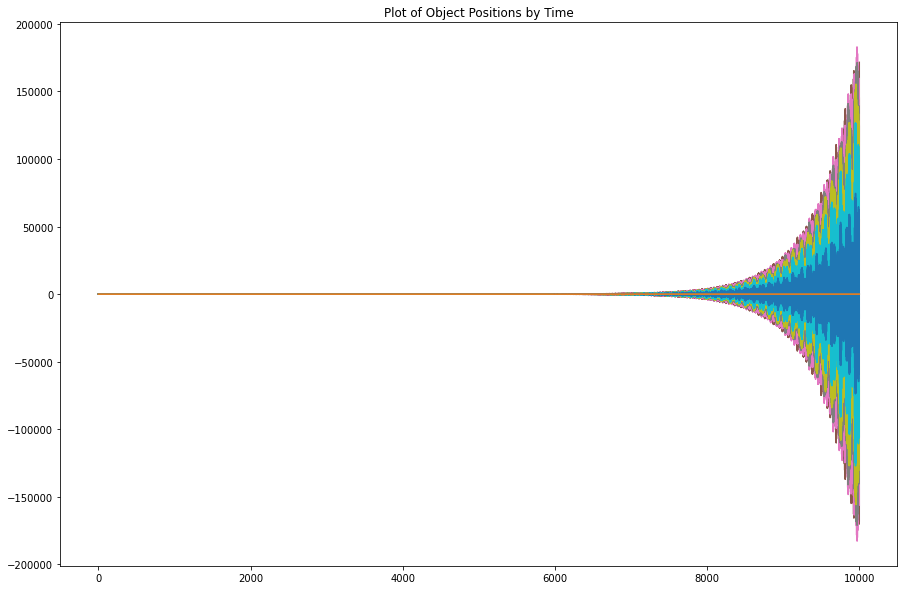

In [19]:
objects[2].displace(0, 0.3)

time = []
for i in range(iters):
    time.append(i*dt)
    for s in springs:
        s.spring_force()
    for obj in objects:
#        damping(obj, gamma)
        obj.Newton()
        obj.timestep()
plt.figure(figsize = (15,10))
plt.title("Plot of Object Positions by Time")
for obj in objects:
    plt.plot(time, obj.xhistory)
plt.show()

Now with the positions as a function of time, we do a fourier transform of each of these graphs. The result are the graphs below which show the dominating frequencies in the motion. 

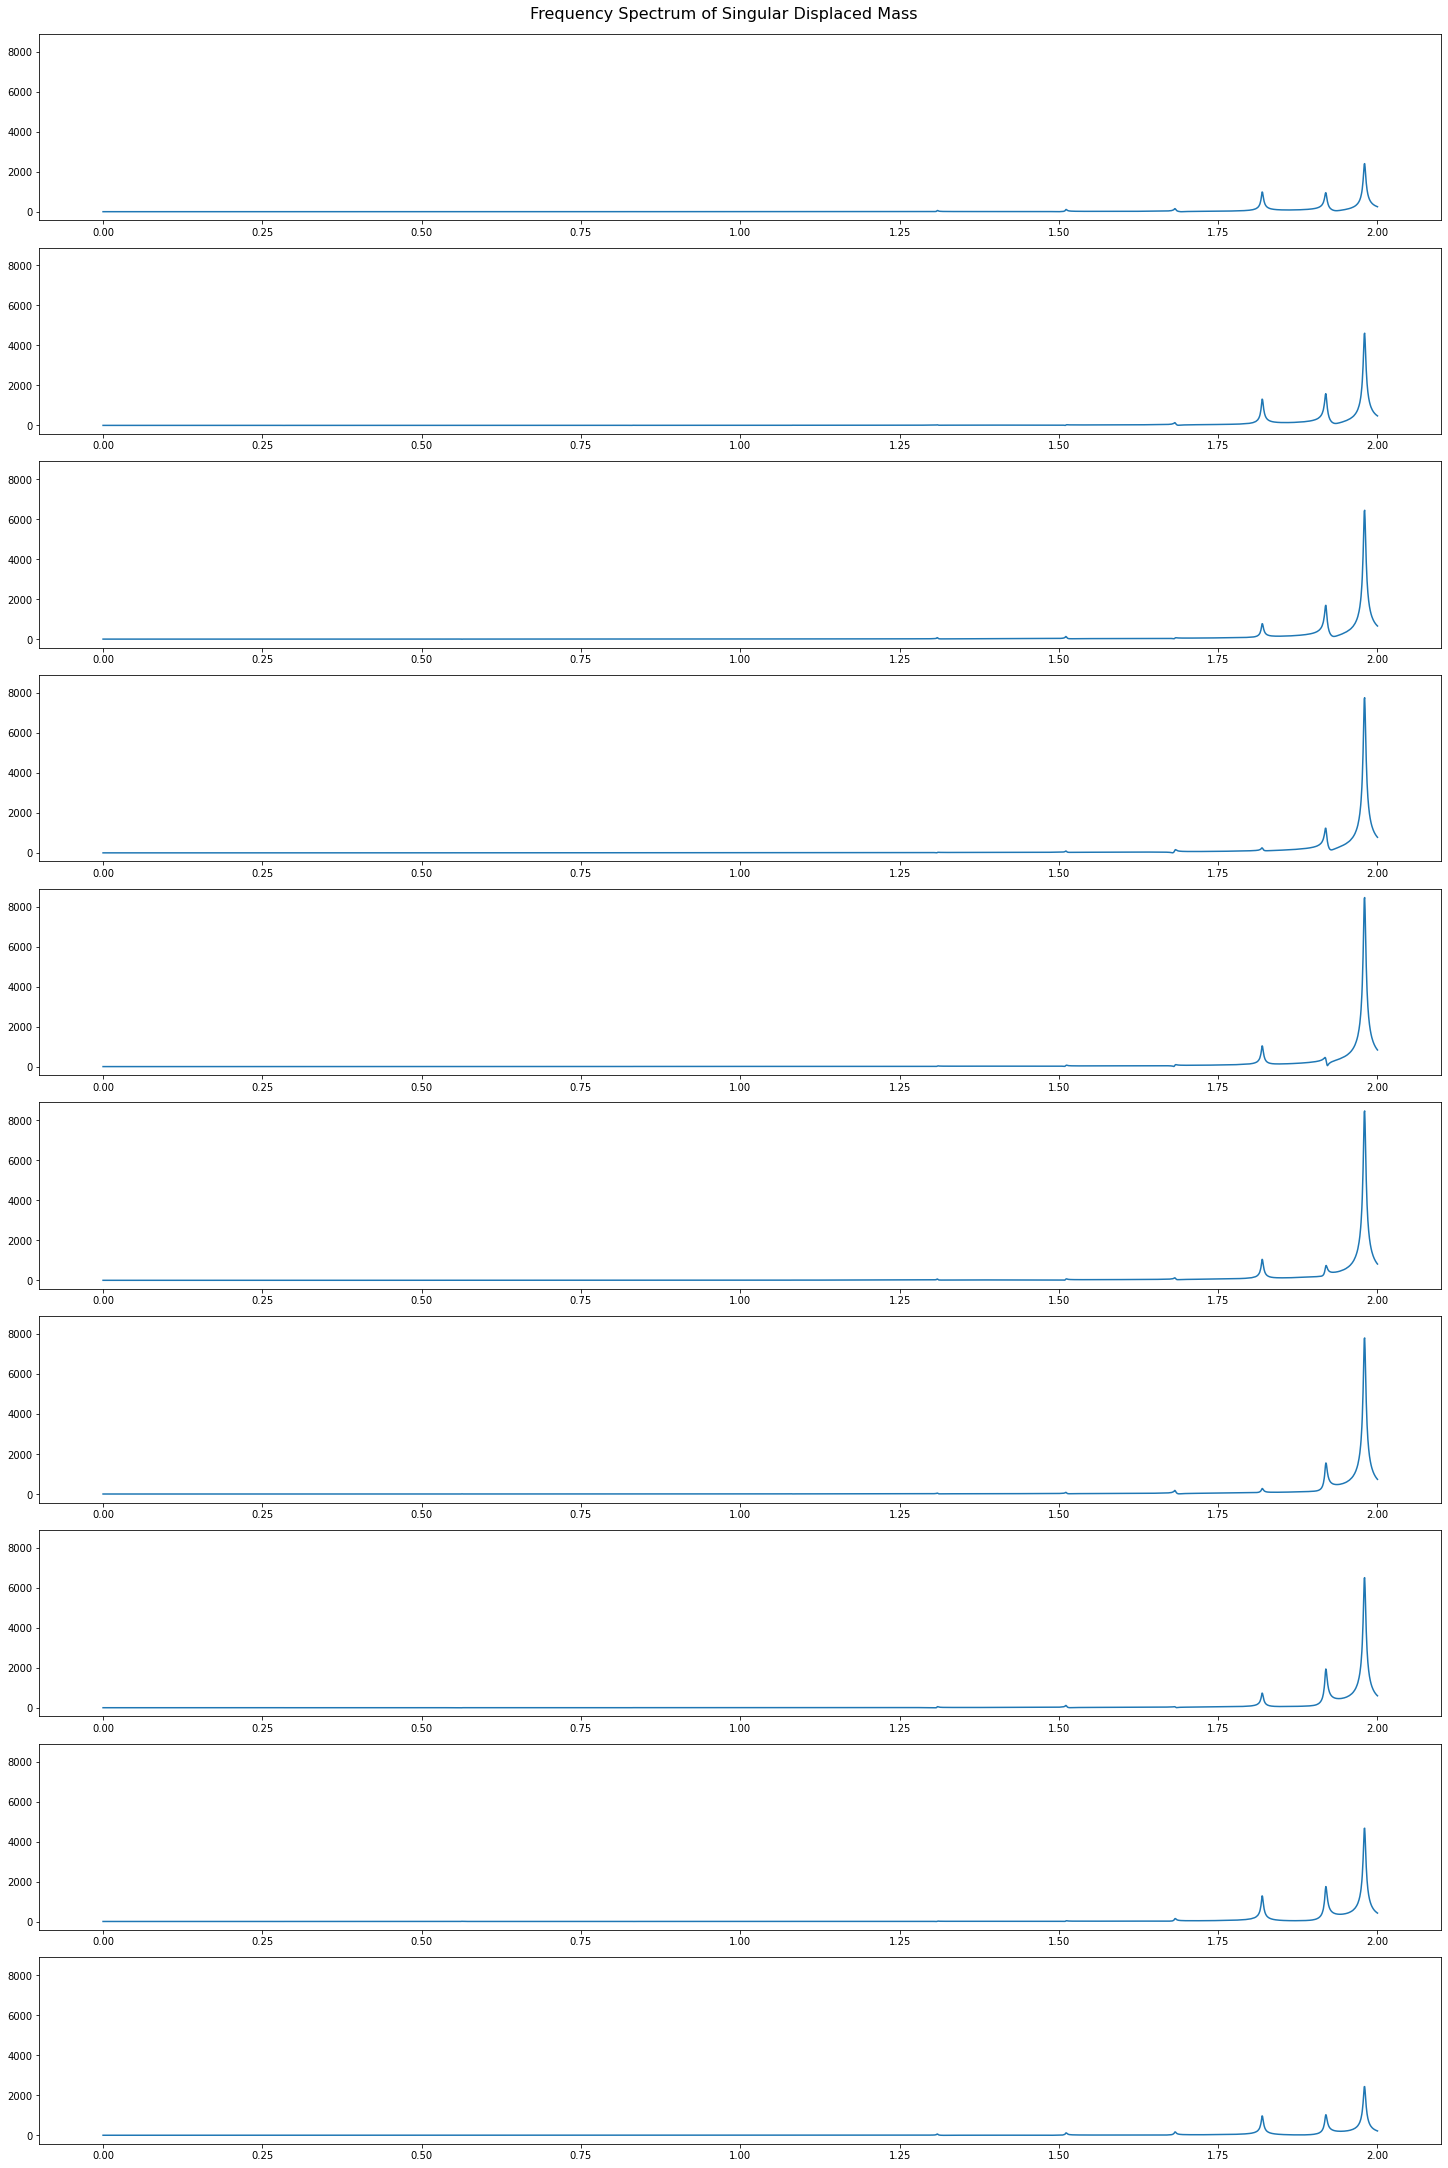

In [20]:
fig, axs = plt.subplots(N, 1, sharey = True, figsize = (20, 3*N), constrained_layout=True)
fig.suptitle("Frequency Spectrum of Singular Displaced Mass", fontsize = 16)
max_freq = 2 / (2 * np.pi)
end_coord = int(max_freq*iters*dt)
graph = 0
for obj in objects[1:N+1]:
    y = obj.xhistory
    yf = np.fft.fft(y)
    yf = 2/iters * np.abs(yf[:iters//2])
    yf = yf[1:end_coord+1]
    xf = 2*np.pi*np.linspace(0.0, max_freq, end_coord)
    axs[graph].plot(xf, yf)
    graph += 1
plt.show()

We can compare the peaks in the spectrum to the theoretical frequencies found using the dispersion relationship. Those frequencies are generated in the script below:

In [21]:
omegas = []
for m in range(1, N + 1):
    omega = np.sqrt(2*k/mass*(1 - np.cos(np.pi*m/(N+1))))
    omegas.append(omega)

read_out = "The theoretical normal modes for this system are: "
for freq in omegas:
    read_out += str(freq) + ", "
print(read_out)

The theoretical normal modes for this system are: 0.28462967654657034, 0.5634651136828593, 0.8308300260037726, 1.081281634911195, 1.3097214678905702, 1.5114991487085165, 1.6825070656623622, 1.8192639907090367, 1.9189859472289947, 1.9796428837618656, 


## Periodic Boundaries

Now we do the same analysis but for periodic boundaries. First we displace a mass, simulate the result and graph the positions as a function of time.

In [22]:
end_time = 500
iters = 500000
N = 10
dt = end_time/iters
l = 1
mass = 5
k = 5
gamma = 0.1
objects = []
springs = []
wall_boundaries = False
periodic = True
if wall_boundaries:
    objects.append(object(x0 = 0, wall = True))
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*(n + 1), dt = dt))
    objects.append(object(x0 = l*(N + 1), wall = True))
    for m in range(N+1):
        springs.append(spring(k, objects[m], objects[m+1], rest_length = l))
        
elif periodic:
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k,objects[m], objects[m+1],rest_length = l))
    springs.append(spring(5, objects[N-1], objects[0], rest_length = l, periodic = True, boundary = l*N))
        
else:
    for n in range(N):
        objects.append(object(mass = mass, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k,objects[m],objects[m+1],rest_length = l))

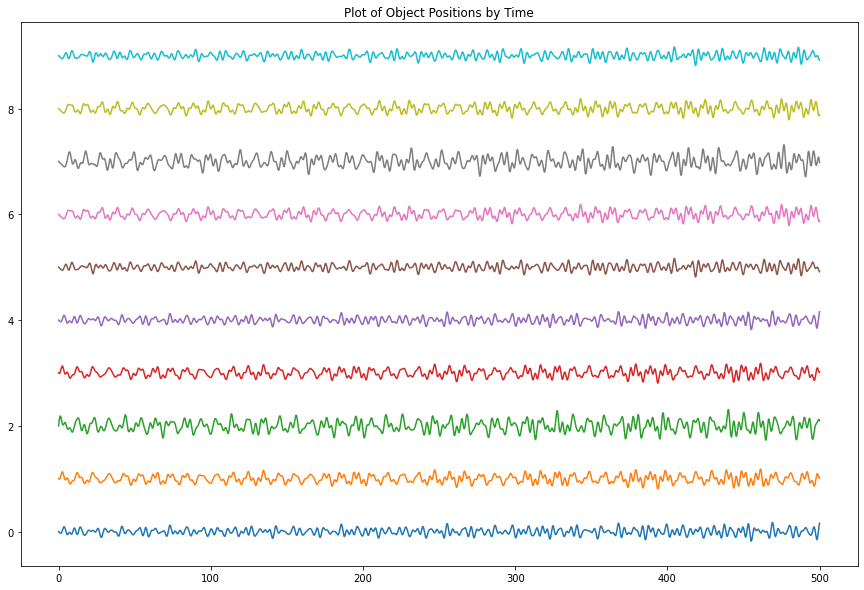

In [23]:
objects[2].displace(0, 0.3)
center(objects)

time = []
for i in range(iters):
    time.append(i*dt)
    for s in springs:
        s.spring_force()
    for obj in objects:
#        damping(obj, gamma)
        obj.Newton()
        obj.timestep()
plt.figure(figsize = (15,10))
plt.title("Plot of Object Positions by Time")
for obj in objects:
    plt.plot(time, obj.xhistory)
plt.show()

Now we generate the fourier transforms of the graphs. As before, we get peaks which correspond to the dominant frequencies in the motion. 

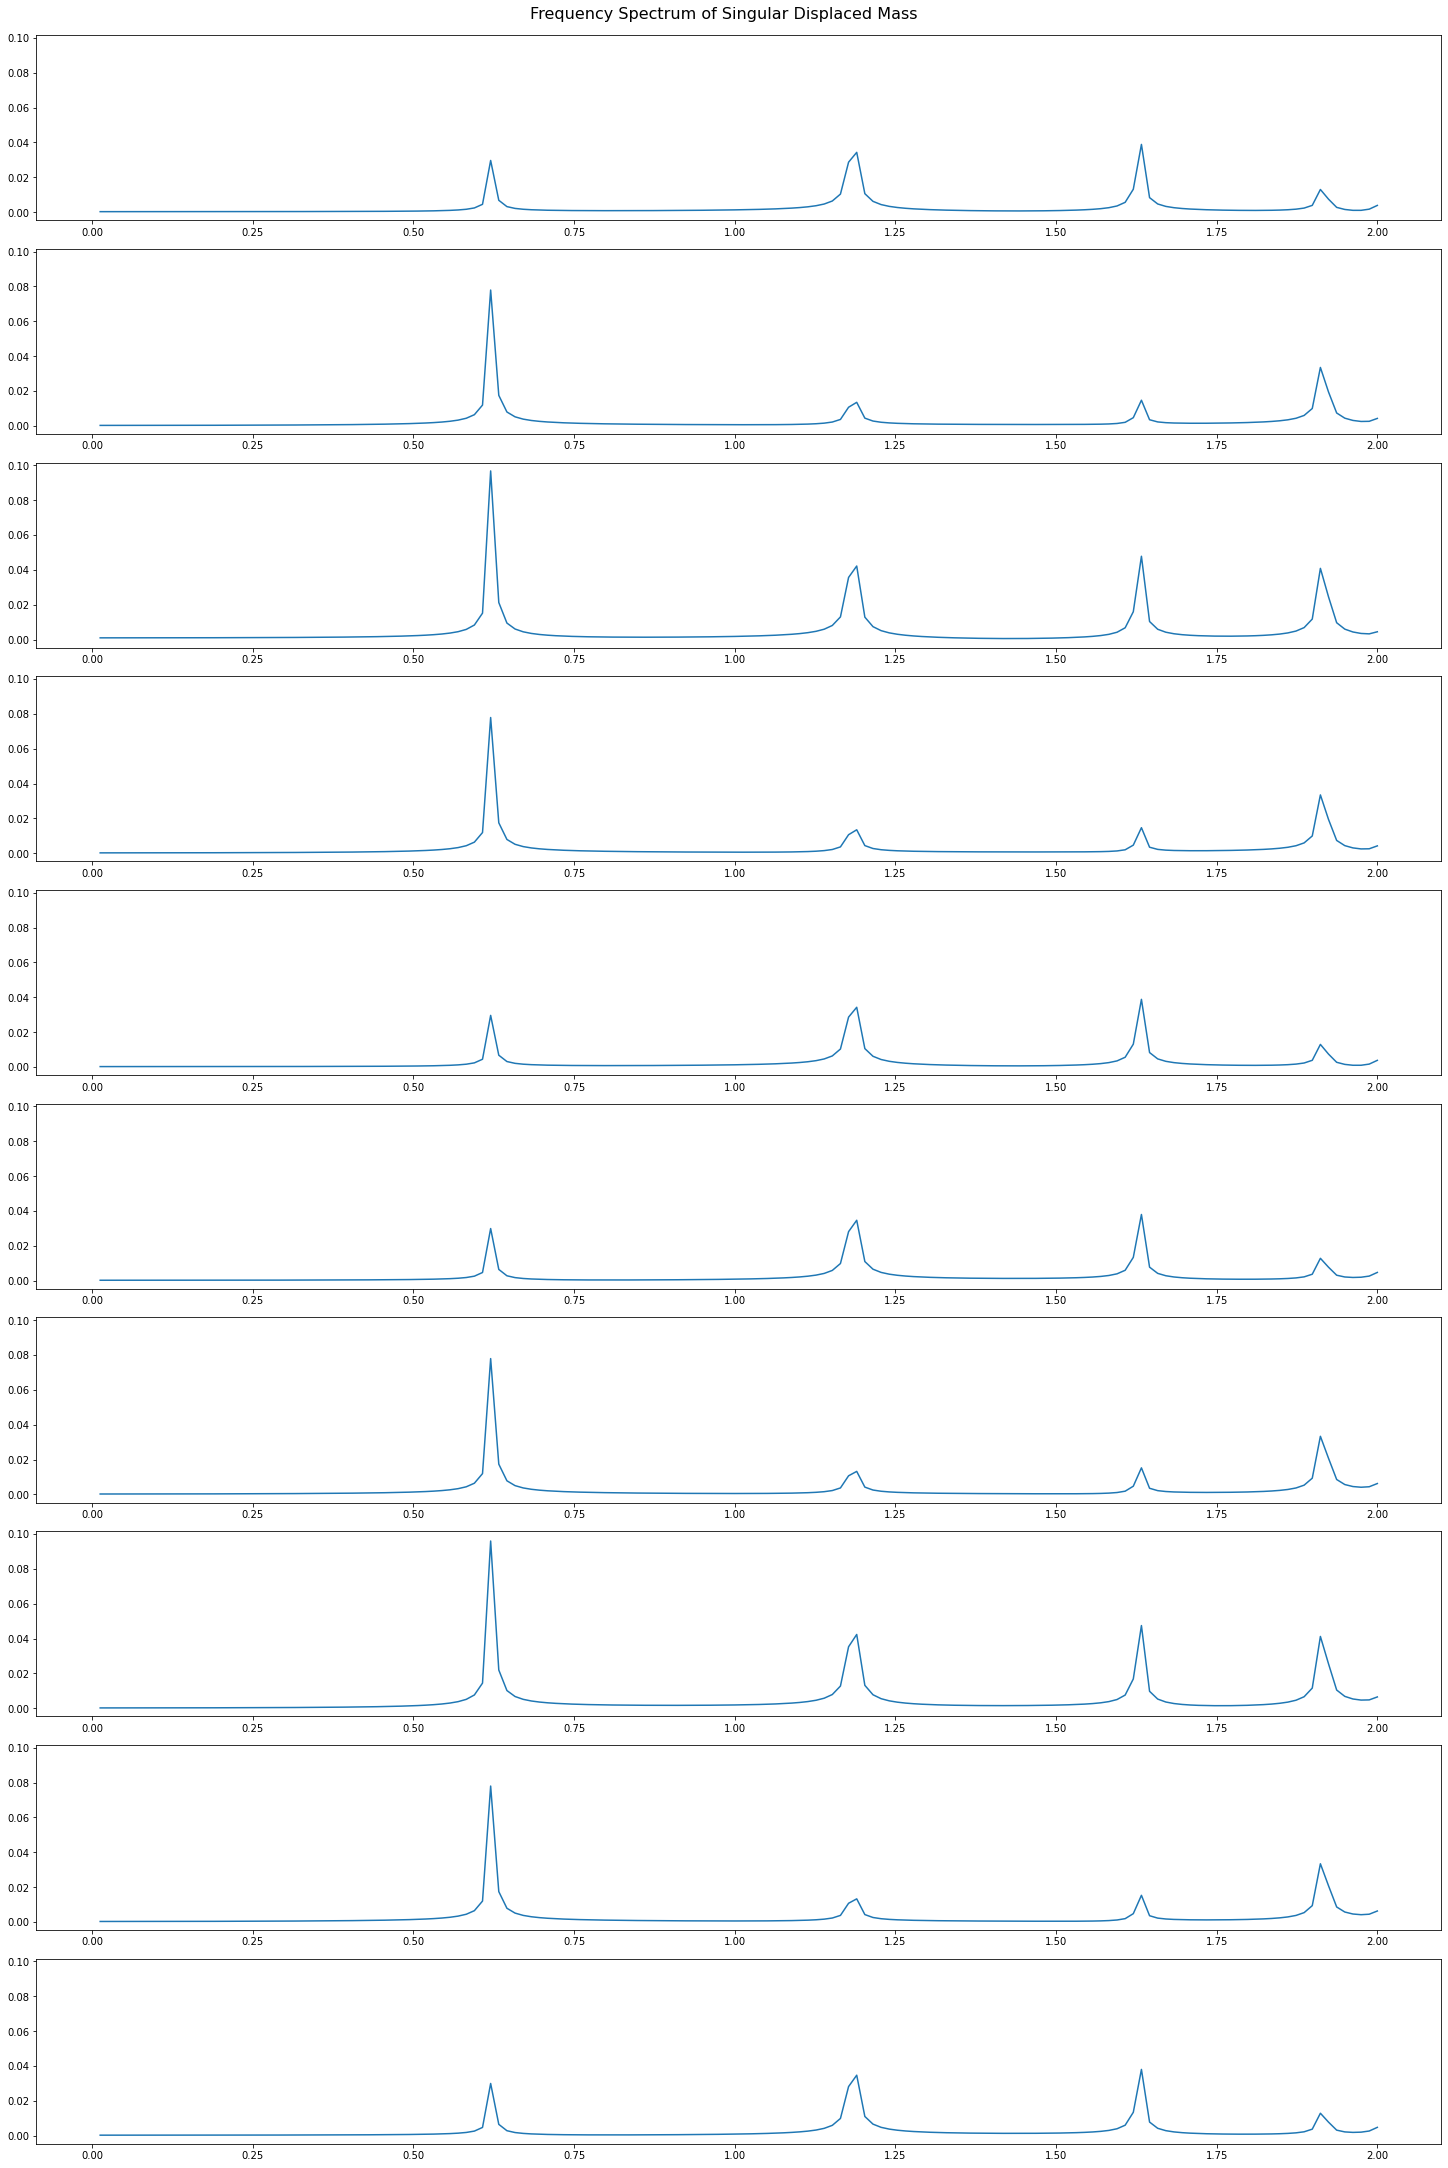

In [24]:
fig, axs = plt.subplots(N, 1, sharey = True, figsize = (20, 3*N), constrained_layout=True)
fig.suptitle("Frequency Spectrum of Singular Displaced Mass", fontsize = 16)
max_freq = 2 / (2 * np.pi)
end_coord = int(max_freq*iters*dt)
graph = 0
for obj in objects:
    y = obj.xhistory
    yf = np.fft.fft(y)
    yf = 2/iters * np.abs(yf[:iters//2])
    yf = yf[0:end_coord]
    yf = yf[1:]
    xf = 2*np.pi*np.linspace(0.0, max_freq, end_coord)
    xf = xf[1:]
    axs[graph].plot(xf, yf)
    graph += 1
plt.show()

We can compare the location of the peaks to the theoretically derived normal modes. Using the dispersion relation, these are:

In [25]:
omegas = []
for m in range(1, int((N+1)/2 + 1)):
    omega = np.sqrt(2*k/mass*(1 - np.cos(2*np.pi*m/N)))
    omegas.append(omega)

read_out = "The normal modes for this system are: "
for freq in omegas:
    read_out += str(freq) + ", "
print(read_out)

The normal modes for this system are: 0.6180339887498948, 1.1755705045849463, 1.618033988749895, 1.902113032590307, 2.0, 
